# Setup

In [1]:
from torch_harmonics.polar_harmonics import PolarHarmonics

In [18]:
K = 2
L = 3
ph = PolarHarmonics(K, L)
ph.Psi.shape

torch.Size([1, 14, 100, 360])

# Plotting the Polar Harmonics

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting

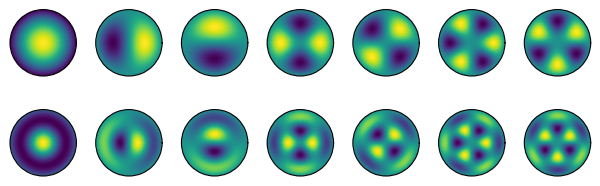

In [20]:
basis_fns = ph.Psi.view(K, L*2+1, ph.num_radii, ph.num_phi)

fig = plt.figure(figsize=(2*L, K))
subfigs = fig.subfigures(K, L*2+1)
for k in range(K):
    for l in range(L*2+1):
            plotting.plot_polar_fn(basis_fns[k,l].numpy(), fig=subfigs[k, l])

# Polar Harmonics Transform

In [5]:
import torch
from torch import nn

In [6]:
r = torch.linspace(0,1,100)
phi = torch.linspace(0,2*np.pi,360)
y = (1-r).view(100,1) @ (np.cos(phi) + np.sin(phi)).view(1,360)

<PolarAxes: >

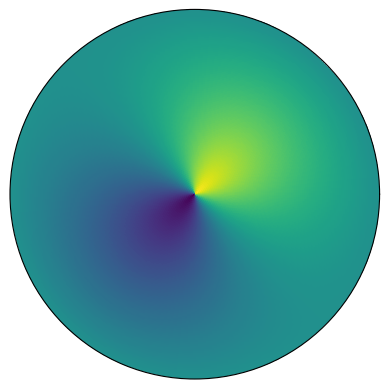

In [7]:
plotting.plot_polar_fn(y.numpy())

In [8]:
class PHT(nn.Module):
    def __init__(self, K=1, L=3, num_radii=100, num_phi=360):
        super().__init__()
        self.w_lin = nn.Linear(num_radii * num_phi, K*(L*2+1))
        self.ph = PolarHarmonics(K,L)

    def forward(self, x, coords=None):
        w = self.w_lin(x)
        return self.ph(w, coords), w.detach()

In [9]:
K = 5
L = 3
ph_model = PHT(K,L)
optimizer = torch.optim.Adam(ph_model.parameters(), lr = 1e-4)

for iter in range(200):
    y_pred, _ = ph_model(y.view(1,-1))
    loss = (y_pred - y).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 1.3164528608322144
iteration: 10 loss: 2.5701518058776855
iteration: 20 loss: 0.8560729622840881
iteration: 30 loss: 0.3770248293876648
iteration: 40 loss: 0.22547975182533264
iteration: 50 loss: 0.08433476090431213
iteration: 60 loss: 0.06431052833795547
iteration: 70 loss: 0.040757786482572556
iteration: 80 loss: 0.04092453420162201
iteration: 90 loss: 0.037873525172472
iteration: 100 loss: 0.03699449077248573
iteration: 110 loss: 0.03672629967331886
iteration: 120 loss: 0.03669329360127449
iteration: 130 loss: 0.036667581647634506
iteration: 140 loss: 0.03665437921881676
iteration: 150 loss: 0.03664810582995415
iteration: 160 loss: 0.03664622828364372
iteration: 170 loss: 0.03664620593190193
iteration: 180 loss: 0.03664591163396835
iteration: 190 loss: 0.036645885556936264


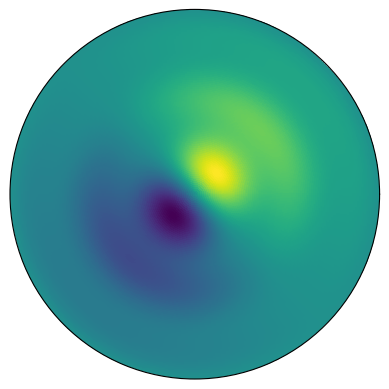

In [10]:
with torch.no_grad():
    pred, w = ph_model(y.view(1,-1))
    plotting.plot_polar_fn(pred.squeeze().numpy())

In [11]:
w_ph = torch.einsum("bwrp,bw->bwrp", ph_model.ph.Psi, w).view(K,2*L+1, ph_model.ph.num_radii, ph_model.ph.num_phi)
w.numpy().round(1).reshape(K, -1)

array([[ 0. ,  0.7,  0.7, -0. , -0. , -0. , -0. ],
       [ 0. ,  0.2,  0.2, -0. , -0. , -0. , -0. ],
       [ 0. ,  0.1,  0.1, -0. , -0. , -0. , -0. ],
       [ 0. ,  0.1,  0.1, -0. , -0. , -0. , -0. ],
       [ 0. ,  0.1,  0.1, -0. , -0. , -0. , -0. ]], dtype=float32)

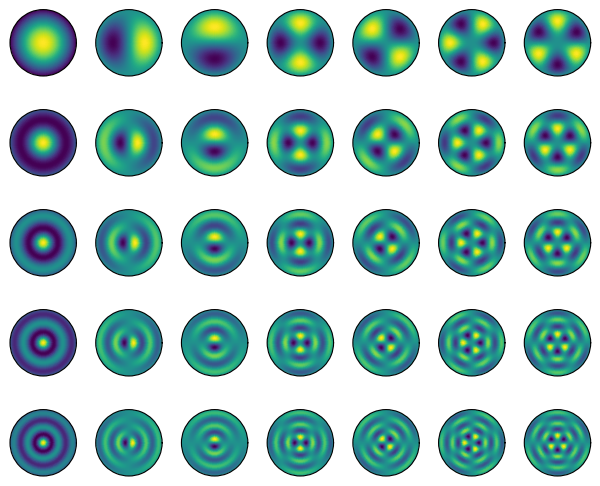

In [12]:
fig = plt.figure(figsize=(2*L, K))
subfigs = fig.subfigures(K, L*2+1)
for k in range(K):
    for l in range(L*2+1):
            plotting.plot_polar_fn(w_ph[k,l].numpy(), fig=subfigs[k, l])

In [13]:
ph_model(y.view(1,-1), torch.tensor([[0.1, np.pi/4]]))[0]

tensor([[[1.1953]]], grad_fn=<SumBackward1>)

In [14]:
from torch_harmonics import grid
r2d, p2d = grid.polar_grid(1., 10, 90)

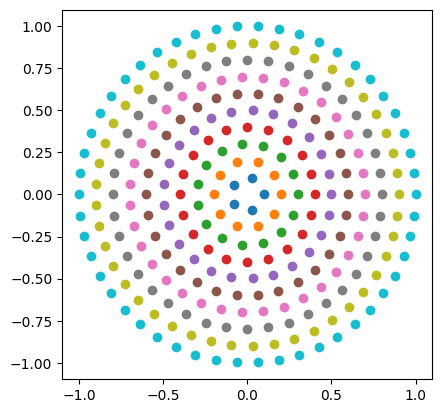

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

n = [5*(i+1) for i in range(10)]
r = np.linspace(0.1, 1, 10)
circles = circle_points(r, n)

fig, ax = plt.subplots()
for circle in circles:
    ax.scatter(circle[:, 0], circle[:, 1])
ax.set_aspect('equal')
plt.show()

In [16]:
p = np.concatenate([np.linspace(0,2*np.pi, i, endpoint=False) for i in n])

In [17]:
r2d, p2d = np.meshgrid(r,p)